<a href="https://colab.research.google.com/github/Logeshwari-2001/Anomaly/blob/main/Anomaly_data_breach_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import sys

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print("pandas : {0}".format(pd.__version__))
print("numpy : {0}".format(np.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("imblearn : {0}".format(imblearn.__version__))

pandas : 1.4.4
numpy : 1.22.4
matplotlib : 3.7.1
seaborn : 0.12.2
sklearn : 1.2.2
imblearn : 0.10.1


DATASET

In [10]:
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
train = pd.read_table("/content/KDDTrain.txt", sep=",", names=datacols) # change path to where the dataset is located.
train = train.iloc[:,:-1] # removes an unwanted extra field

# Load NSL_KDD test dataset
test = pd.read_table("/content/KDDTest.txt", sep=",", names=datacols)
test = test.iloc[:,:-1]

VIEWING THE TRAIN DATA AND DIMENSION

In [11]:
print(train.head(4))

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          1                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0           0             0         0                   0           0   
1           0             0         0                   0           0   
2           0 

VIEWING TEST DATA AND DIMENSION

In [12]:
print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp   private  REJ          0          0     0   
1         0           tcp   private  REJ          0          0     0   
2         2           tcp  ftp_data   SF      12983          0     0   
3         0          icmp     eco_i   SF         20          0     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          0                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0           0             0         0                   0           0   
1           0             0         0                   0           0   
2           0 

DATA PREPROCESSING Mapping which means we are considering four types of attacks(dos,u2r,r2l,probe) and then we are having many types under these categories mapping is the process which map these numerous attacks to their respective prime attack fields.

In [13]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [14]:
train['attack_class'] = train['attack'].apply(lambda v: mapping[v])
test['attack_class'] = test['attack'].apply(lambda v: mapping[v])

dropping attack field(i.e replacing the sub attacks with the prime attack names)sub attack->neptune which is replaced by its respective prime attack dos.

In [15]:
train.drop(['attack'], axis=1, inplace=True)
test.drop(['attack'], axis=1, inplace=True)

In [16]:
train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS


STATISTICS

In [17]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


REMOVING THE UNNECESSARY FIELDS FROM THE DATASET

In [18]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    125973
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [19]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [20]:
train['attack_class'].value_counts()

Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: attack_class, dtype: int64

In [21]:
attack_class_freq_train = train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1) 
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


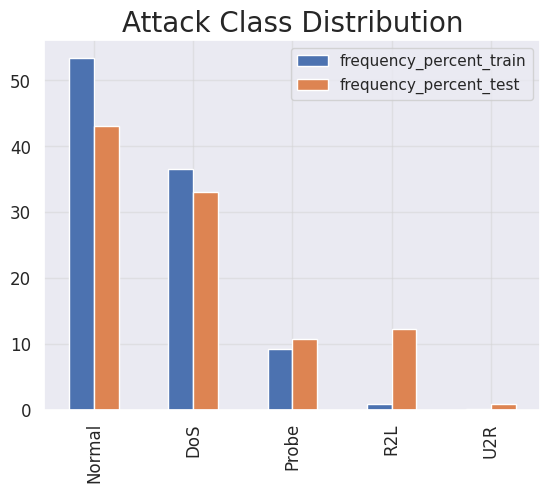

In [22]:
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

SCALING NUMERICAL ATTRIBUTES

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

ENCODING CATEGORICAL ATTRIBUTES

In [24]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['attack_class'], axis=1)
cat_Ytrain = traincat[['attack_class']].copy()

In [25]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['attack_class']
train_x.shape

(125973, 40)

In [26]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 41)

FEATURE SELECTION USING RANDOM FOREST CLASSIFIER

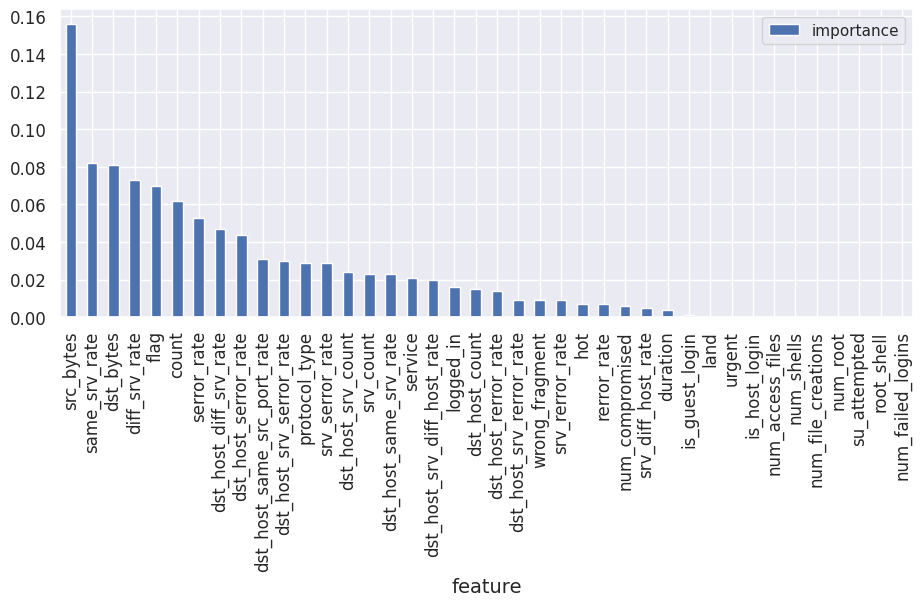

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [28]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'count',
 'srv_count',
 'serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'protocol_type',
 'service',
 'flag']

In [29]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

TRAINING THE MODEL

In [30]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

#Train SVM Model
SVC_Classifier = SVC(random_state=0)
SVC_Classifier.fit(X_train, Y_train)


SVC(random_state=0)

EVALUATING THE MODEL

In [31]:
from sklearn import metrics

models = []
models.append(('SVM Classifier', SVC_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

for i, v in models:
    #scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    #print ("Cross Validation Mean Score:" "\n", scores.mean())
    #print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== SVM Classifier Model Evaluation ==============================

Model Accuracy:
 0.9725110851543983

Confusion matrix:
 [[31239   893    28     0     0]
 [   86 46987   132     0     6]
 [   76   521  7476     0     0]
 [   10   655     0    41     0]
 [    1    15     1     0    14]]

Classification report:
               precision    recall  f1-score   support

         DoS       0.99      0.97      0.98     32160
      Normal       0.96      1.00      0.98     47211
       Probe       0.98      0.93      0.95      8073
         R2L       1.00      0.06      0.11       706
         U2R       0.70      0.45      0.55        31

    accuracy                           0.97     88181
   macro avg       0.93      0.68      0.71     88181
weighted avg       0.97      0.97      0.97     88181



============================== LogisticRegression Model Evaluation ==============================

Model Accuracy:
 0.9513047028271396

Confusion matrix:
 [[31263   8